In [1]:
#%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy import signal
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot
import h5py
from simple_edf_preprocessing import Preprocessor
from datetime import datetime
import warnings

In [2]:
#create a ECOG PCA class for its PCA object, hyperparas and other stuff
class Feature_generator:
    def __init__(self,path,pca_obj=None,wsize=30, prefiltered=True):
        self.pca=pca_obj
        #hyperpara in s for how large the time window should be on whihc we calculate our fourier trafo
        self.wsize=wsize
        #sampling frequency and last sample taken
        df=h5py.File(path)
        self.sfreq=int(df['f_sample'][()])
        #TODO THIS IS ENTERED MANUALLY FOR DAY 4, PAT c46fd46!!! CHANGE TO READ FROM FILE ONCE AVAILBABLE
        ###so the actual portion of the data we want is this, in s
        self.start=11
        self.end=43205
        #preprocess data
        preprocessor=Preprocessor(df,start_sample=int(self.start*self.sfreq),end_sample=int(self.end*self.sfreq))
        self.data,self.bad_chan,self.bad_idx=preprocessor.preprocess(prefiltered_sd_kurt=prefiltered)
        self.data=self.data[self.bad_chan!=True]
        self.chan_labels=np.array(eval(df['chanLabels'][()]))[self.bad_chan!=True]
        #how many samples in this dataset?
        self._bin_data()
        self.pca=None
            
    
    #this function restructures the data into a 3D structure, where each row presents a channel, each column one second
    #and the depth is the amount of samples per seconds (sfreq). 
    #This is to discard seconds where bad_idx are present and to be on par with the labels in the end
    #This function also creates a mask of bins to discard from the bad_idx array
    def _bin_data(self):
        #where to end?
        self.data_bin=self.data.reshape(self.data.shape[0],self.end-self.start,self.sfreq)
        self.mask_bin=np.all(self.bad_idx.reshape(self.end-self.start,self.sfreq),axis=1)

      
    def _standardize(self, data,ax=0):
        self.data_mean=np.mean(data,axis=ax)
        data_dem=data-self.data_mean
        std=np.std(data,axis=ax)
        data_stand=data_dem/std
        #self.data_scal=1000000
        #data_scal=self.data_scal*data_dem
        #return data_scal
        return data_stand
    
#this function caps at 150Hz, then bins the data in a logarithmic fashion to account for smaller psd values in higher freqs
    def _bin_psd(self,fr,psd):
        fr_trun=fr[fr<=150]
        fr_total=len(fr_trun)
        fr_bins=np.arange(int(np.log2(max(fr_trun))+1))
        #truncate everythin above 150Hz
        psd=psd[:,fr<=150]
        psd_bins=np.zeros((psd.shape[0],len(fr_bins)))
        prev=0
        #these are the general upper limits. they don't give info where in fr/psd these frequencies acutally are!
        max_psd_per_bin=np.exp2(fr_bins).astype('int')
        #hence we need this method:
        prev=0
        limits=np.zeros((max_psd_per_bin.shape[0],2),dtype='int')
        for en,b in enumerate(max_psd_per_bin):
            if en==0:
                arr=np.where((fr_trun >=prev)&(fr_trun<=b))[0]
            else:
                arr=np.where((fr_trun >prev)&(fr_trun<=b))[0]
            check=np.array([min(arr),max(arr)])
            limits[np.log2(b).astype('int')]=check
            prev=b
        prev=0
        for b in fr_bins:
            if (b==fr_bins[-1] or limits[b][1]>=fr_total):
                psd_bins[:,b]+=np.sum(psd[:,limits[b,0]:],axis=1)
            else:
                psd_bins[:,b]=np.sum(psd[:,limits[b,0]:limits[b,1]+1],axis=1)
        return fr_bins, psd_bins

        
    #create matrix as follows:
    #columns: channels, for each channel the 200 frequencies (0-200Hz) (hece freq*cha length) BUT BINNED logarithmically
    #rows: Time steps
    #resulting matrix is 2D, Time Stepsx(Freq*Channels)
    #note that this matrix is prone to constant change. Save the current data as member variable
    #NEW: Option to do this with a sliding window of length wsize
    def _calc_features(self,time_sta,time_stp, sliding_window=False):
        time_it=time_sta
        while True:
            stop=time_it+self.wsize
            if stop>=self.data_bin.shape[1]-1:
                print('Not enough data for set end %d. Returning all data that is available in given range.'% time_stp)
                break
                
            #Note that each column is exactly one second.
            #get data in range of ALL channels, applying the following mask to filter out seconds with a bad index
            mask=np.ma.compressed(np.ma.masked_array(range(time_it,stop),mask=self.mask_bin[time_it:stop]))
            curr_data=self.data_bin[:,mask,:].reshape(self.data.shape[0],-1)
            
            #is this thing empty? continue
            if not curr_data.size:
                print('Warning. A whole chunck of %d s of data was thrown away here. Check if this is correct' %wsize)
                if(sliding_window):
                    time_it+=1
                else:
                    time_it+=self.wsize
                if time_it+self.wsize >= time_stp:
                    break
                continue
                
            #welch method 
            fr,psd=signal.welch(curr_data,self.sfreq,nperseg=250)
            fr_bin,psd_bin=self._bin_psd(fr,psd)
            if time_it==time_sta:
                self.fr_bin=fr_bin
                #first time. create first column, flatten w/o argument is row major 
                mat=psd_bin.flatten()
            else:
                #after, add column for each time step
                mat=np.column_stack((mat,psd_bin.flatten()))
            #sliding window?
            if (sliding_window):
                time_it+=1
            else:
                time_it+=self.wsize
            if time_it+self.wsize >= time_stp+1:
                break
                
        self.temp_mat=mat.T
        data_scal=self._standardize(mat.T)
        self.curr_data=data_scal
        return data_scal
    
    def vis_raw_data(self, start, stop, chans=None):
        if chans is None:
            chans=range(self.data.shape[0])
        st=int(start*self.sfreq)
        stp=int(stop*self.sfreq)
        data=self.data[chans,st:stp]
        for p in range(0,len(chans)-1):
            plt.plot(data[p])
        plt.show()
    
    def vis_welch_data(self,start,stop,chans=None):
        #account for wsize
        start=int(start/self.wsize)
        stop=int(stop/self.wsize)
        rem=self.curr_data[:,start:stop]
        plt.imshow(rem,cmap='viridis',aspect='auto')
        
    def vis_pc(self):
        if self.pca is None:
            raise ValueError('PCA not set up yet. Please call setup_PCA first.')
        for p in range(self.pca.n_components):
            plt.plot(self.pca.transform(self.curr_data)[:,p])
        plt.xlabel('Time (in w_size)')
        plt.ylabel('PC Value')
        plt.title('First %d principal components' % self.pca.n_components)
        plt.show()

    #get elbow curve. This also outputs the optimal n_components for the given desired explained variancce.
    def __elbow_curve(self,datapart,expl_var_lim):
        components = range(1, datapart.shape[1] + 1)
        explained_variance = []
        #till where?
        lim=min(100, datapart.shape[1])
        count=0
        for component in tqdm(components[:lim]):
            pca = PCA(n_components=component)
            pca.fit(datapart)
            expl_var=sum(pca.explained_variance_ratio_)
            explained_variance.append(expl_var)
            count+=1
            if(expl_var>(expl_var_lim/100.)):
                optimal_no_comps=count
                break
        if(explained_variance[-1:][0]<(expl_var_lim/100.)):
            print('Could not explain more than %d %% of the variance. n_comps is set to match this. Consider increasing data range or lowering demanded explained variance' % expl_var*100)
            optimal_no_comps=components[-1:]
        sns_plot = sns.regplot(
            x=np.array(components[:count]), y=explained_variance,
            fit_reg=False).get_figure()
        return optimal_no_comps
    
    def _setup_PCA(self,train,expl_variance):
        if not train and self.pca is None:
            raise ValueError('Train set has to be generated first, otherwise no principal axis available for data trafo.')
        if train:
            print('Setting up PCA on current data range...')
            no_comps=self.__elbow_curve(self.curr_data,expl_variance)
            self.pca=PCA(n_components=no_comps)
            self.pca.fit(self.curr_data)
        return self.pca.transform(self.curr_data)
    
    def generate_features(self,start=0,end=None, sliding_window=False, train=True,expl_variance=85):
        self._calc_features(time_sta=start, time_stp=end, sliding_window=sliding_window)
        princ_components=self._setup_PCA(train=train,expl_variance=expl_variance)
        return princ_components
        
        

In [3]:
pecog=Feature_generator('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5',prefiltered=False,wsize=100)

# for p in range(pecog.pca.n_components):
#     plt.plot(wut[:,p])
# plt.xlabel('Time (in w_size)')
# plt.ylabel('PC Value')
# plt.title('First %d principal components' % pecog.pca.n_components)
# plt.show()

# pecog.vis_raw_data(0,30000,range(20))

# #pecog.vis_raw_data(idx[0]-5,idx[1]+5)
# #pecog.vbis_raw_data(0,idx[1]+400)
# pecog.vis_welch_data(0,30000)



# good_data=pecog.calc_data_mat(idx[1]+100,idx[1]+400)
# pecog.pca.fit(good_data)
# good_data_trafo=pecog.pca.transform(good_data)
# print(good_data_trafo.shape)
# print(good_data.shape)


# print(good_data.shape)
# print(good_data_trafo.shape)

# comps=pecog.pca.components_
# print(pecog.raw.info['ch_names'][28])
# print(comps.shape)
# comps=comps.reshape((127,-1,2))
# print(np.argmax(comps[:,:,1],axis=1))
# #plt.plot(comps[5:,5:,0].T)
# plt.plot(comps[:,:,1].T)
# plt.ylim(-0.005,0.005)

# print(len(pecog.raw.info['chs']))

# #print(data_trafo)
# plt.plot(good_data_trafo[:,0])
# plt.plot(good_data_trafo[:,1])
# #plt.xlim(-0.00001,0.00001)
# #plt.ylim(-0.00001,0.00001)

# #max(data_trafo[:,1])-min(data_trafo[:,1])

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up PCA on current data range...


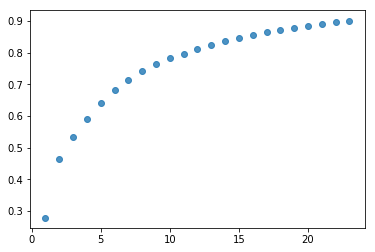

In [4]:
wut=pecog.generate_features(0,12500,expl_variance=90)

# print(wut.shape)


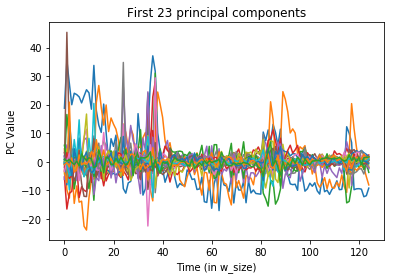

In [5]:
pecog.vis_pc()

In [14]:
pecog.curr_data.shape


(30, 592)

In [15]:
kk=np.arange(24).reshape(4,6)
kk.reshape(4,2,3)

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23]]])

(592, 280)


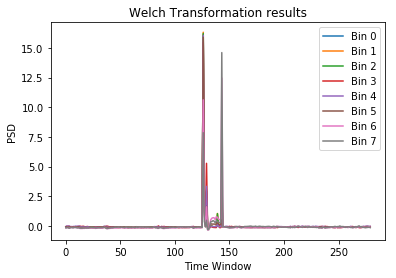

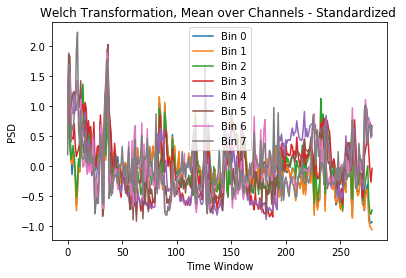

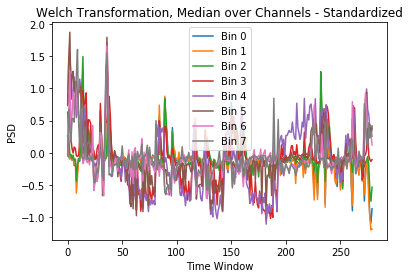

(592, 280)


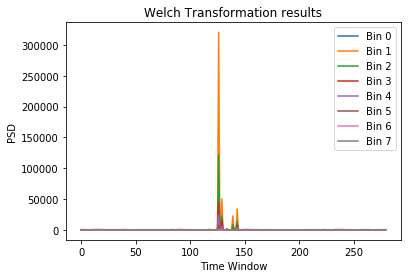

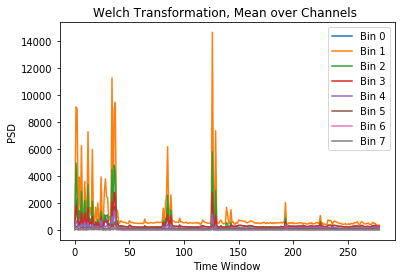

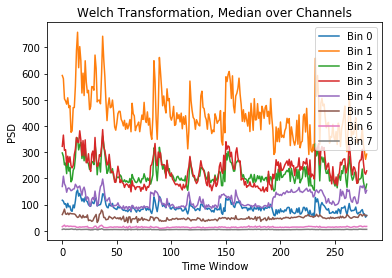

In [51]:
lel=pecog.curr_data.T
med=np.median(lel.reshape(-1,8,lel.shape[1]),axis=0)
men=np.mean(lel.reshape(-1,8,lel.shape[1]),axis=0)
print(lel.shape)
for i in range(8):
    plt.plot(lel[8*8+i,:], label='Bin %d' %i)
plt.legend()
plt.xlabel('Time Window')
plt.ylabel('PSD')
plt.title('Welch Transformation results')
plt.show()
for i in range(8):
    plt.plot(men[i,:], label='Bin %d' %i)
plt.legend()
plt.xlabel('Time Window')
#plt.yscale('log')
plt.ylabel('PSD')
plt.title('Welch Transformation, Mean over Channels - Standardized ')
plt.show()

for i in range(8):
    plt.plot(med[i,:], label='Bin %d' %i)
plt.legend()
plt.xlabel('Time Window')
#plt.yscale('log')
plt.ylabel('PSD')
plt.title('Welch Transformation, Median over Channels - Standardized')
plt.show()



lel=pecog.temp_mat.T
med=np.median(lel.reshape(-1,8,lel.shape[1]),axis=0)
men=np.mean(lel.reshape(-1,8,lel.shape[1]),axis=0)
print(lel.shape)
for i in range(8):
    plt.plot(lel[8*8+i,:], label='Bin %d' %i)
plt.legend()
plt.xlabel('Time Window')
plt.ylabel('PSD')
plt.title('Welch Transformation results')
plt.show()
for i in range(8):
    plt.plot(men[i,:], label='Bin %d' %i)
plt.legend()
plt.xlabel('Time Window')
#plt.yscale('log')
plt.ylabel('PSD')
plt.title('Welch Transformation, Mean over Channels ')
plt.show()

for i in range(8):
    plt.plot(med[i,:], label='Bin %d' %i)
plt.legend()
plt.xlabel('Time Window')
#plt.yscale('log')
plt.ylabel('PSD')
plt.title('Welch Transformation, Median over Channels')
plt.show()

In [4]:
f=h5py.File('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5')

In [5]:
sprr=f['dataset'][()]

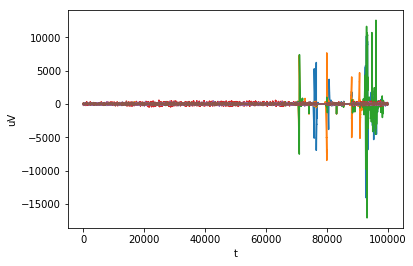

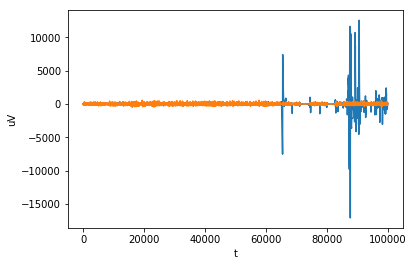

In [8]:
for i in range(8,14):
    plt.plot(sprr[i,125*100*500:127*100*500])
plt.xlabel('t')
plt.ylabel('uV')
plt.show()
for i in range(10,12):
    plt.plot(pecog.data[i,125*100*500:127*100*500])
plt.xlabel('t')
plt.ylabel('uV')
plt.show()

Text(0.5,1,'One Patient, Sample Channels')

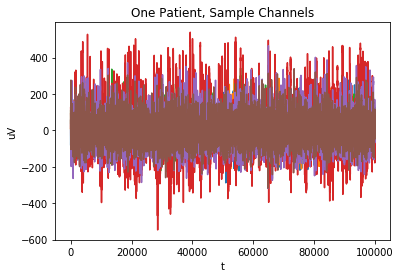

In [6]:
for i in range(8,14):
    plt.plot(sprr[i,10*100*500:12*100*500])
plt.xlabel('t')
plt.ylabel('uV')
plt.title('One Patient, Sample Channels')

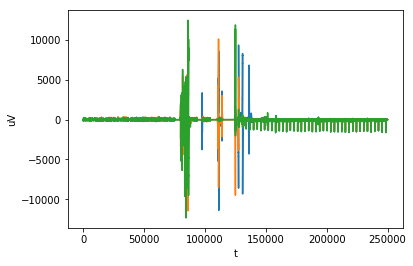

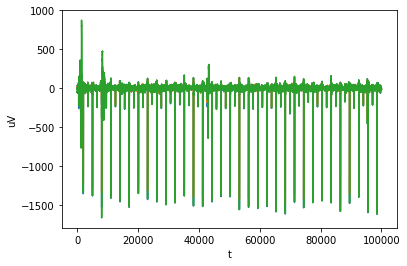

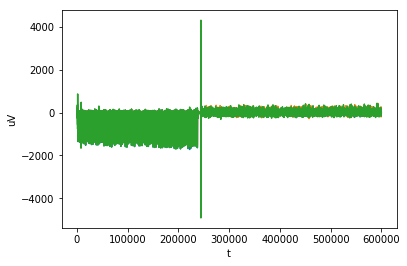

In [11]:
for i in range(25,28):
    plt.plot(pecog.data[i,35*100*500:40*100*500])
plt.xlabel('t')
plt.ylabel('uV')
plt.show()

for i in range(25,28):
    plt.plot(pecog.data[i,38*100*500:40*100*500])
plt.xlabel('t')
plt.ylabel('uV')
plt.show()

for i in range(25,28):
    plt.plot(pecog.data[i,38*100*500:50*100*500])
plt.xlabel('t')
plt.ylabel('uV')
plt.show()

In [84]:
np.argmax(lel.reshape(-1,8,lel.shape[1])[:,1,34])

27

In [ ]:
pecog.generate_features()

In [ ]:
ttest=np.abs(featuregen.pca.transform(np.eye(pecog.curr_data.shape[1])))

In [19]:
ttest_sum[:16]

array([ 0.80206583,  0.78311655,  0.62571233,  0.39279292,  0.33486912,
        0.42157061,  0.37944906,  0.45407633,  0.51535645,  0.43426241,
        0.36810476,  0.41921405,  0.36437429,  0.4432273 ,  0.42817033,
        0.53478033])

In [21]:
ttest_sum[:16].reshape(-1,8)

array([[ 0.80206583,  0.78311655,  0.62571233,  0.39279292,  0.33486912,
         0.42157061,  0.37944906,  0.45407633],
       [ 0.51535645,  0.43426241,  0.36810476,  0.41921405,  0.36437429,
         0.4432273 ,  0.42817033,  0.53478033]])

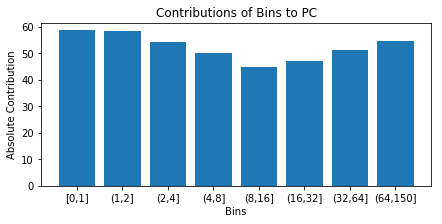

Text(0.5,1,'Contributions of Chans to PC')

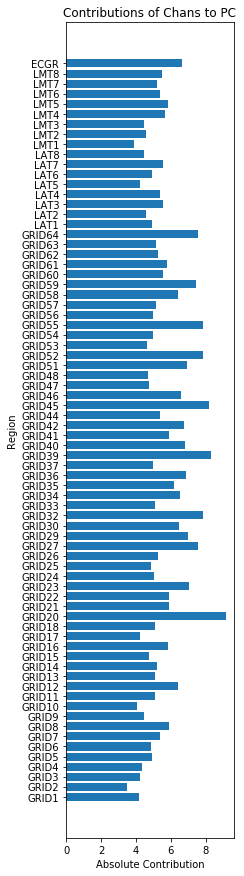

In [68]:
#how much did each bin contribute?
ttest_sum=ttest.sum(axis=1)
ttest_shaped=ttest_sum.reshape(pecog.data.shape[0],-1)
cont_bins=ttest_shaped.sum(axis=0)
cont_elecs=ttest_shaped.sum(axis=1)
plt.figure(figsize=(7,3))
plt.bar(np.arange(len(cont_bins)),cont_bins)
ticks=['[0,1]','(1,2]','(2,4]','(4,8]','(8,16]','(16,32]','(32,64]','(64,150]']
plt.xticks(np.arange(len(cont_bins)),ticks)
plt.title('Contributions of Bins to PC')
plt.xlabel('Bins')
plt.ylabel('Absolute Contribution')
plt.show()

plt.figure(figsize=(3,15))
plt.barh(np.arange(len(cont_elecs)),cont_elecs)
plt.yticks(np.arange(len(cont_elecs)),list(pecog.chan_labels))
plt.ylabel('Region')
plt.xlabel('Absolute Contribution')
plt.title('Contributions of Chans to PC')

In [53]:
len(cont_elecs)==len(list(pecog.chan_labels))

True